In [1]:
from spectral import *
import spectral.io.envi as envi
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import matplotlib

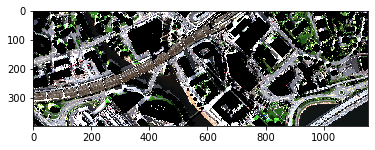

In [2]:
image = envi.open('../../hyperImage/stacked/ref/09_training_masked.hdr', '../../hyperImage/stacked/ref/09_training_masked.')
img = image.load()
view = imshow(img, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)))

In [3]:
img = img[:,:, :467]

In [4]:
img.shape

(397, 1153, 467)

In [5]:
#compute PCA on the image 
pc = principal_components(img)
pc_0999 = pc.reduce(fraction=0.999)
img_pc = pc_0999.transform(img)
img_pc.shape

(397, 1153, 71)

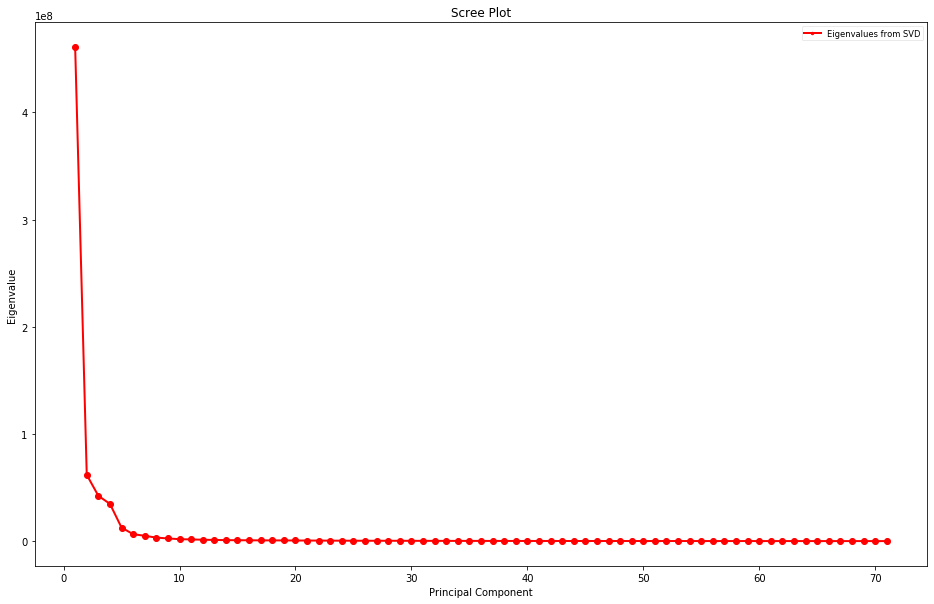

In [6]:
eigvals = pc_0999.eigenvalues
num_vars = 71


fig = plt.figure(figsize=(16, 10))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()

In [8]:
pc_img = img_pc[:,:, :7]

In [9]:
#NDVI calculation of the image 
vi = ndvi(image, 76, 105)
data_ndvi = np.nan_to_num(vi)

/opt/anaconda3/lib/python3.7/site-packages/spectral/algorithms/algorithms.py:1216: RuntimeWarning: invalid value encountered in true_divide
  return (n - r) / (n + r)


In [10]:
pc_img.shape

(397, 1153, 7)

In [11]:
## Combine PCA,and ndvi DATA
df_pca = pd.DataFrame(pc_img.reshape(-1, pc_img.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, pc_img.shape[2]+1)]
df_ndvi = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi.columns = [string]
#Concatenate 3 dataframe 
main_df = pd.concat([df_pca, df_ndvi], axis=1, sort=False)

In [12]:
main_df.to_csv('../../hyperImage/csv/features/Stacked_HSI_feature2', index=False)



In [ ]:
main_df = pd.read_csv('../../hyperImage/csv/features/Stacked_HSI_feature2')

In [ ]:
main_df

<function matplotlib.pyplot.show(*args, **kw)>

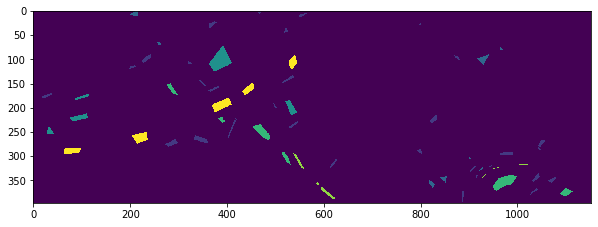

In [13]:
## Class image
gt_data = Image.open('../../hyperImage/stacked/ref/classref.tif')
gt = np.array(gt_data)
plt.figure(figsize=(10, 10))
plt.imshow(gt)
plt.show

In [14]:
np.unique(gt)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [15]:
df_class = pd.DataFrame(gt.reshape(-1, 1))
string = "Target"
df_class.columns = [string]

# Using only hyperspectral data 

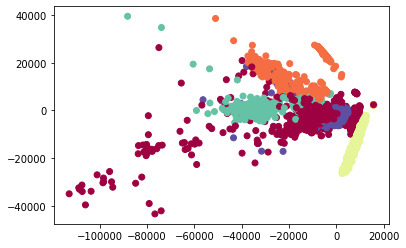

In [16]:
df = pd.concat([main_df, df_class], axis=1, sort=False)
df_masked = df[(df[['Target']] != 0). all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')
plt.show()

In [17]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [19]:
random_forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=2, n_jobs= -1)
random_forest.fit(X_train, y_train)
pred = random_forest.predict(X_test)
accuracy_score(y_test, pred)

0.9686069326357096

In [20]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=2, n_jobs= -1)
random_forest2.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [21]:
X_data = df.drop(columns=['Target']).values
X_data_scaled = scaler.transform(X_data)

In [22]:
y_pred = random_forest2.predict(X_data_scaled)

In [23]:
predicted_hsi_mask = y_pred.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

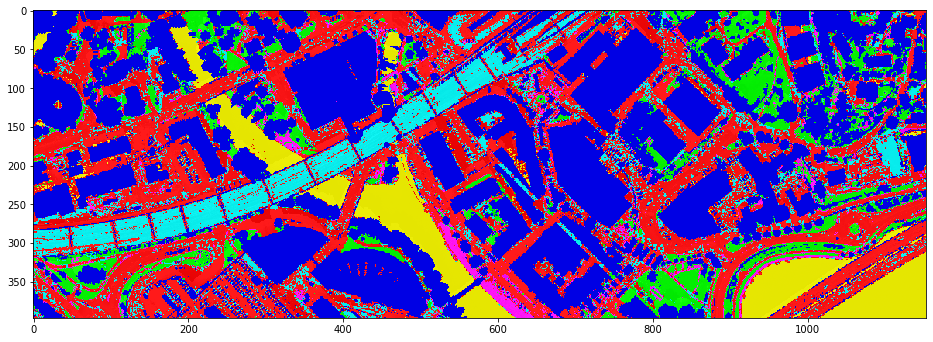

In [24]:
#full_image = envi.open('../hyperImage/09_full_image.hdr', '../hyperImage/09_full_image.')
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask)
view.set_display_mode('overlay')
view.class_alpha = 0.9
view.show_data

In [25]:
road = (predicted_hsi_mask == 1).astype(int)

In [26]:
from skimage.feature import canny
from skimage.viewer import ImageViewer
from skimage import io
from skimage import img_as_uint
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)
#viewer = ImageViewer(edges)
#viewer.show()
road_edges = edges.astype(int)



/opt/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

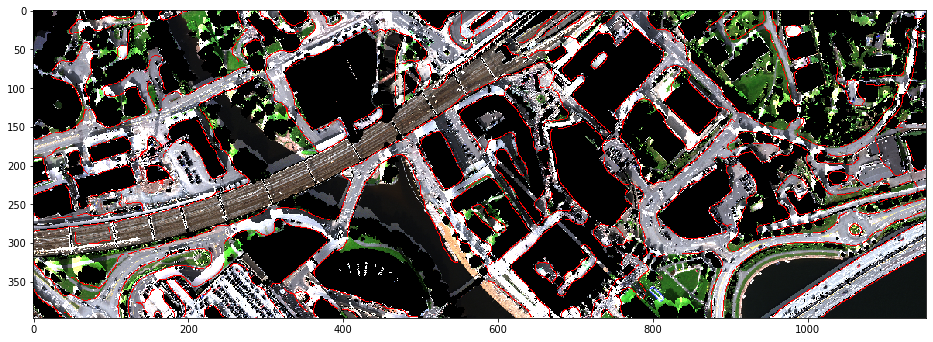

In [27]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation

In [28]:
val_image = envi.open('../../hyperImage/stacked/ref/validation/08_vali_masked.hdr', '../../hyperImage/stacked/ref/validation/08_vali_masked.')
val_img = val_image.load()
val_img.shape

(342, 983, 467)

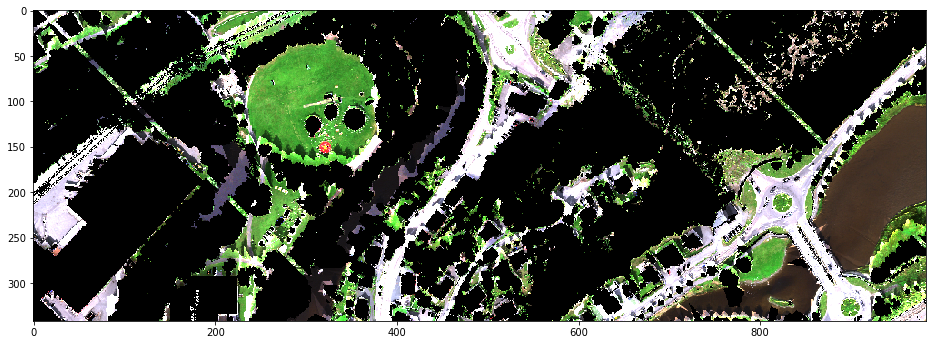

In [29]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16))

In [30]:
val_img.shape

(342, 983, 467)

In [31]:
#compute PCA on the image 
pc = principal_components(img)
pc_0999 = pc.reduce(fraction=0.999)
val_img_pc = pc_0999.transform(val_img)
val_img_pc.shape

(342, 983, 71)

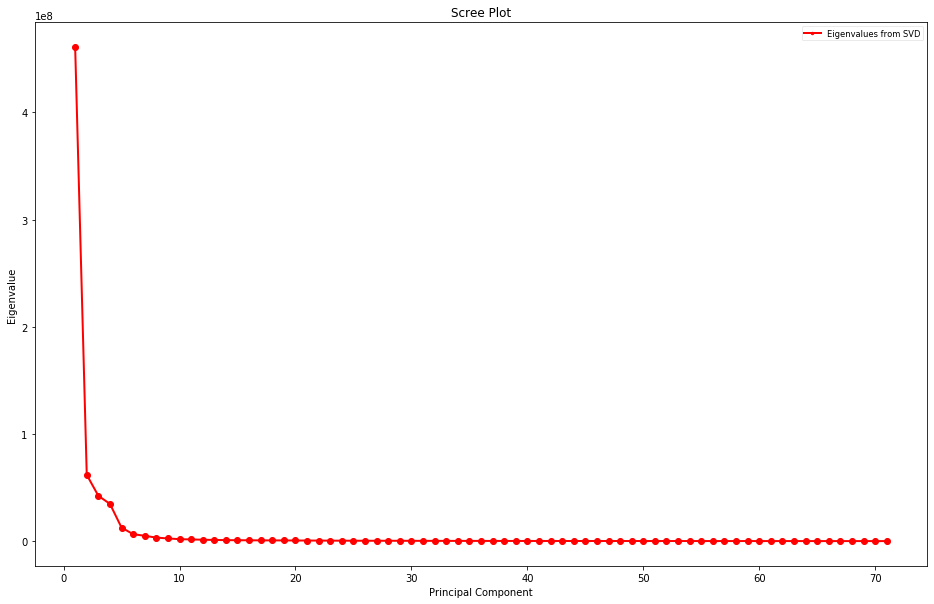

In [32]:
eigvals = pc_0999.eigenvalues
num_vars = 71


fig = plt.figure(figsize=(16, 10))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()

In [33]:
pc_img = val_img_pc[:,:, :7]
pc_img.shape

(342, 983, 7)

In [34]:
df_pca = pd.DataFrame(pc_img.reshape(-1, pc_img.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, pc_img.shape[2]+1)]
main_df_val = pd.concat([df_pca], axis=1, sort=False)

In [35]:
main_df_val.to_csv('../../hyperImage/csv/features/Stacked_HSI_feature_val1', index=False)

In [ ]:
main_df_val = pd.read_csv('../../hyperImage/csv/features/Stacked_HSI_feature_val1')

In [ ]:
main_df_val

In [36]:
#NDVI calculation of the image 
vi = ndvi(val_image, 76, 105)
data_ndvi = np.nan_to_num(vi)

/opt/anaconda3/lib/python3.7/site-packages/spectral/algorithms/algorithms.py:1216: RuntimeWarning: invalid value encountered in true_divide
  return (n - r) / (n + r)


In [37]:
df_ndvi_val = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi_val.columns = [string]
#Concatenate 3 dataframe 
main_df_val = pd.concat([main_df_val, df_ndvi_val], axis=1, sort=False)

In [38]:
main_df_val_scaled = scaler.transform(main_df_val)
hsi_val_pred = random_forest.predict(main_df_val_scaled)
predicted_hsi_mask_val = hsi_val_pred.reshape(342, 983)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 849.0]
    G: [0.0, 825.0]
    B: [0.0, 626.0]
>

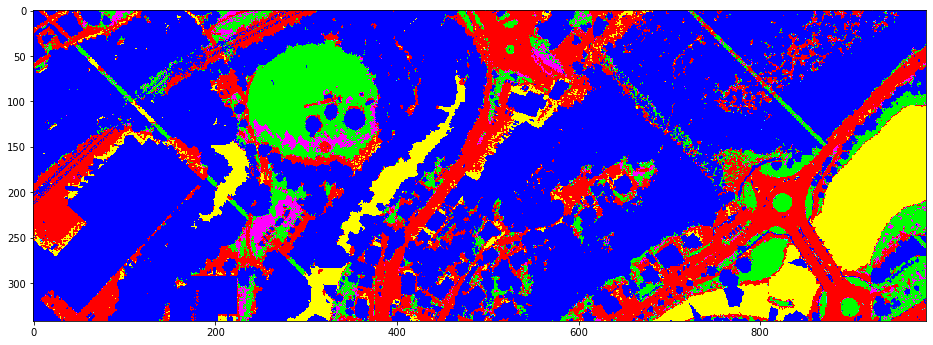

In [39]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [40]:
## Class image
gt_data_val = Image.open('../../hyperImage/stacked/ref/validation/val_class.tif')
gt_val = np.array(gt_data_val)
gt_val.shape

(342, 983)

In [41]:
df_class_val = pd.DataFrame(gt_val.reshape(-1, 1))
string = "Target"
df_class_val.columns = [string]
df_class_val.shape

(336186, 1)

In [42]:
df_hsi_val = pd.concat([main_df_val, df_class_val], axis=1, sort=False)

In [43]:
df_hsi_val

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,NDVI,Target
0,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,0
1,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,0
2,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,0
3,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,0
4,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,0
...,...,...,...,...,...,...,...,...,...
336181,-8064.910934,-9739.830008,-3453.354840,-8706.614458,1378.451921,-1683.734928,11067.595105,-0.007535,0
336182,-7837.351509,-8610.728510,-3706.605468,-8143.885480,3392.596091,293.014037,8223.361623,0.008403,0
336183,-4391.655865,-7840.302319,-6476.892967,-10493.144030,6515.412895,1668.413859,9734.503741,-0.007376,0
336184,-4877.482333,-7526.412976,-6535.301045,-11488.744431,5705.424739,1637.411175,9927.133068,-0.011854,0


In [44]:
df_hsi_val_masked = df_hsi_val[(df_hsi_val[['Target']] != 0).all(axis=1)]
X_val = df_hsi_val_masked.drop(columns=['Target']).values
y_val = df_hsi_val_masked['Target'].values

In [45]:
X_data_scaled_val = scaler.transform(X_val)
y_pred = random_forest.predict(X_data_scaled_val)

In [46]:
accuracy_score(y_val, y_pred)

0.7940066831949983

In [47]:
target_names = ['Road', 'Vegetation', 'Soil','Unclassified', 'Water', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.87      0.99      0.93      3456
  Vegetation       0.99      0.62      0.76      5566
        Soil       0.58      0.99      0.73      4439
Unclassified       0.98      0.82      0.90      4135
       Water       0.41      0.01      0.02       940
 Train Track       0.00      0.00      0.00        18

    accuracy                           0.79     18554
   macro avg       0.64      0.57      0.56     18554
weighted avg       0.84      0.79      0.78     18554



In [48]:
cohen_kappa_score(y_val, y_pred)

0.7303929146004716

In [49]:
confusion_matrix(y_val, y_pred)

array([[3431,    0,   15,    9,    1,    0],
       [ 102, 3467, 1967,   14,   16,    0],
       [  27,    0, 4412,    0,    0,    0],
       [  16,    0,  709, 3410,    0,    0],
       [ 342,   32,  507,   34,   12,   13],
       [  13,    0,    0,    5,    0,    0]])

# Using Lidar Data Only

In [50]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../hyperImage/stacked/ref/intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../../hyperImage/stacked/ref/nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [51]:
df_lidar = pd.concat([df_intensity, df_dsm, df_class], axis=1, sort=False)
df_lidar.to_csv('../../hyperImage/csv/features/Stacked_lidar_features', index=False)

In [52]:
df_lidar = pd.read_csv('../../hyperImage/csv/features/Stacked_lidar_features')

In [53]:
df_lidar

,Lidar Intensity,Lidar nDSM,Target
0,27.0,25.160000,0
1,6.0,23.369999,0
2,7.0,23.279999,0
3,15.0,24.029999,0
4,1.0,21.400000,0
...,...,...,...
457736,12.0,0.050000,0
457737,6.0,0.020000,0
457738,13.0,0.020000,0
457739,9.0,0.060000,0


In [54]:
df_lidar_masked =  df_lidar[(df_lidar[['Target']] != 0). all(axis=1)]
X = df_lidar_masked.drop(columns=['Target']).values
y = df_lidar_masked['Target'].values

In [55]:
scaler1 = StandardScaler()
scaler1.fit(X)
X_scaled = scaler1.transform(X)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [57]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest2.fit(X_train, y_train)
pred = random_forest2.predict(X_test)
accuracy_score(y_test, pred)

0.7282537606278614

In [58]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [59]:
X_lidar_data = df_lidar.drop(columns=['Target']).values
S_lidar_data_scaled = scaler1.transform(X_lidar_data)
y_pred_lidar = random_forest3.predict(S_lidar_data_scaled)
predicted_lidar_mask = y_pred_lidar.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

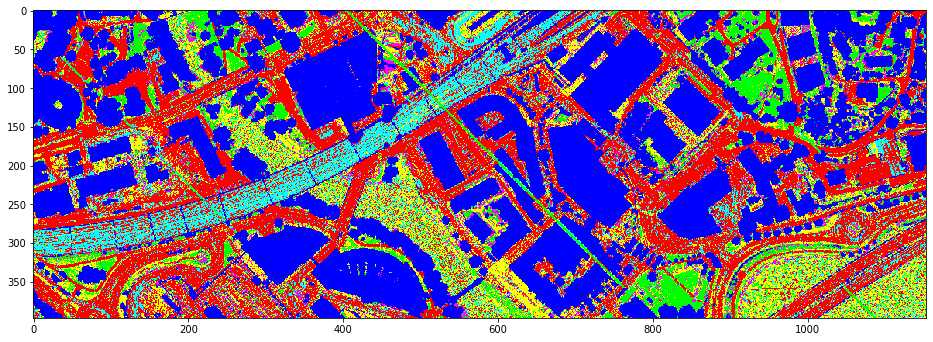

In [60]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [61]:
road = (predicted_lidar_mask == 1).astype(int)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)

road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

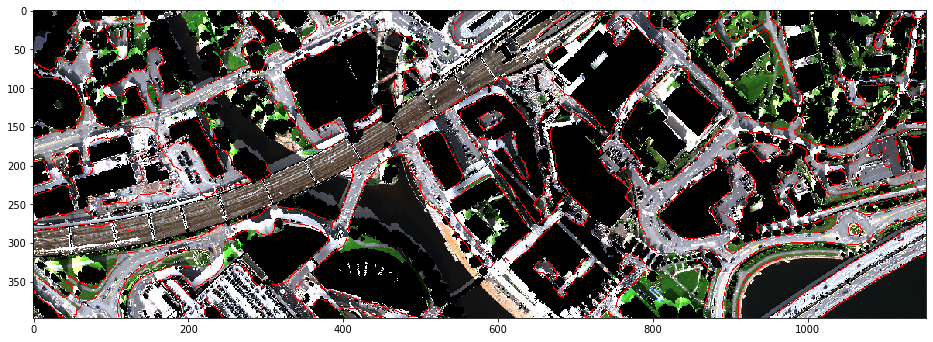

In [63]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

## Validation

In [64]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../hyperImage/stacked/ref/validation/intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../../hyperImage/stacked/ref/validation/nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [65]:
l_intensity.shape

(342, 983)

In [66]:
df_lidar_val = pd.concat([df_intensity, df_dsm], axis=1, sort=False)
df_lidar_val.to_csv('../../hyperImage/csv/features/Stacked_lidar_features_val1', index=False)

In [67]:
df_lidar_val = pd.read_csv('../../hyperImage/csv/features/Stacked_lidar_features_val1')

In [68]:
df_lidar_val

,Lidar Intensity,Lidar nDSM
0,16.0,29.960000
1,15.0,29.940000
2,16.0,29.940000
3,19.0,29.910000
4,17.0,29.920000
...,...,...
336181,23.0,0.009999
336182,25.0,0.010000
336183,23.0,0.090000
336184,19.0,0.040001


In [69]:
X_data_val_scaled = scaler1.transform(df_lidar_val.values)
y_pred = random_forest3.predict(X_data_val_scaled)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 849.0]
    G: [0.0, 825.0]
    B: [0.0, 626.0]
>

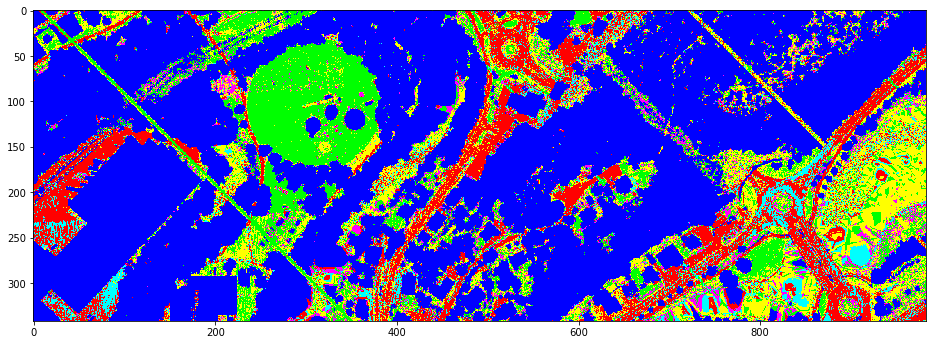

In [70]:
predicted_lidar_mask = y_pred.reshape(342, 983)
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [71]:
df_lidar_val = pd.concat([df_lidar_val, df_class_val], axis=1, sort=False)

In [72]:
df_lidar_val_masked = df_lidar_val[(df_lidar_val[['Target']] != 0).all(axis=1)]
X_val = df_lidar_val_masked.drop(columns=['Target']).values
y_val = df_lidar_val_masked['Target'].values

In [73]:
X_data_scaled_val = scaler1.transform(X_val)
y_pred = random_forest3.predict(X_data_scaled_val)

In [74]:
accuracy_score(y_val, y_pred)

0.6460601487549854

In [75]:
target_names = ['Road', 'Vegetation', 'Water','Unclassified', 'Soil', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.82      0.76      0.79      3456
  Vegetation       0.82      0.57      0.67      5566
       Water       0.59      0.99      0.74      4439
Unclassified       0.68      0.41      0.52      4135
        Soil       0.20      0.08      0.11       940
 Train Track       0.00      0.06      0.00        18

    accuracy                           0.65     18554
   macro avg       0.52      0.48      0.47     18554
weighted avg       0.70      0.65      0.65     18554



In [76]:
confusion_matrix(y_val, y_pred)

array([[2640,   28,    6,  197,   13,  572],
       [  35, 3161, 1952,  323,   72,   23],
       [  25,    0, 4400,    4,    2,    8],
       [ 458,  599,  644, 1711,  207,  516],
       [  55,   67,  459,  260,   74,   25],
       [  12,    1,    0,    4,    0,    1]])

In [77]:
cohen_kappa_score(y_val, y_pred)

0.5450582302423851

# Using fused hyperspectral and lidar data 

In [78]:
#merge with HSI dataframe and lidar dataframe

In [79]:
df_lid_hsi = pd.concat([main_df, df_lidar], axis=1, sort=False)

In [80]:
df_lid_hsi

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,NDVI,Lidar Intensity,Lidar nDSM,Target
0,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,27.0,25.160000,0
1,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,6.0,23.369999,0
2,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,7.0,23.279999,0
3,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,15.0,24.029999,0
4,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,1.0,21.400000,0
...,...,...,...,...,...,...,...,...,...,...,...
457736,7737.628246,-16309.066270,-3661.362721,-12040.625230,-13044.009313,-3495.551775,-4574.305953,-0.248120,12.0,0.050000,0
457737,7748.289489,-16296.678562,-3649.517438,-12016.427725,-13086.135134,-3513.153788,-4552.437574,-0.248120,6.0,0.020000,0
457738,8217.377297,-14388.769373,-3030.807183,-10525.927561,-10403.337512,-1619.384367,-5848.810551,-0.246377,13.0,0.020000,0
457739,8214.458492,-14370.537465,-3050.055966,-10503.676101,-10427.457899,-1636.555196,-5841.948785,-0.234899,9.0,0.060000,0


In [81]:
df_masked =  df_lid_hsi[(df_lid_hsi[['Target']] != 0). all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values

In [82]:
scaler3 = StandardScaler()
scaler3.fit(X)
X_scaled = scaler3.transform(X)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_train, y_train)
pred = random_forest3.predict(X_test)
accuracy_score(y_test, pred)

0.974166121648136

In [84]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [85]:
X_data = df_lid_hsi.drop(columns=['Target']).values
X_data_scaled = scaler3.transform(X_data)

In [86]:
y_pred = random_forest3.predict(X_data_scaled)

In [87]:
predicted_hsi_lidar_mask = y_pred.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

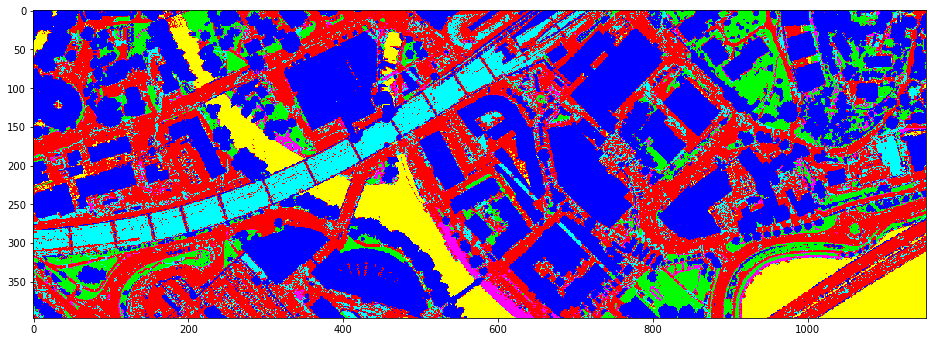

In [88]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [89]:
road = (predicted_hsi_lidar_mask == 1).astype(int)

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

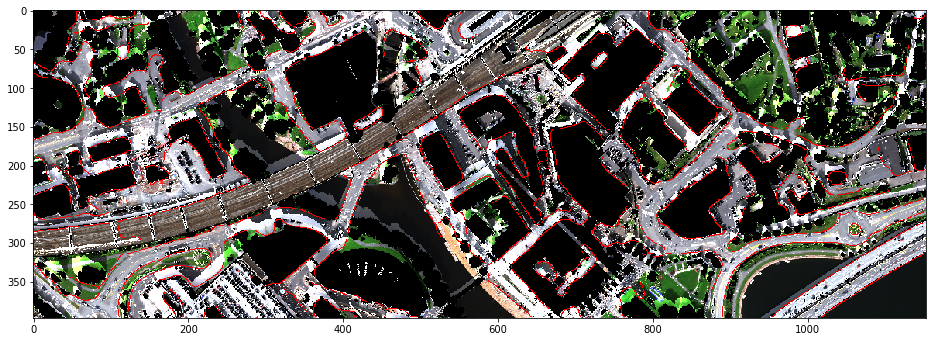

In [91]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation


In [92]:
main_df = pd.read_csv('../../hyperImage/csv/features/Stacked_HSI_feature_val1')
point_cloud_val= pd.read_csv('../../hyperImage/csv/features/Stacked_lidar_features_val1')
df_lid_hsi = pd.concat([main_df, df_ndvi_val, point_cloud_val], axis=1, sort=False)
df_lid_hsi

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,NDVI,Lidar Intensity,Lidar nDSM
0,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,16.0,29.960000
1,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,15.0,29.940000
2,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,16.0,29.940000
3,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,19.0,29.910000
4,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,17.0,29.920000
...,...,...,...,...,...,...,...,...,...,...
336181,-8064.910934,-9739.830008,-3453.354840,-8706.614458,1378.451921,-1683.734928,11067.595105,-0.007535,23.0,0.009999
336182,-7837.351509,-8610.728510,-3706.605468,-8143.885480,3392.596091,293.014037,8223.361623,0.008403,25.0,0.010000
336183,-4391.655865,-7840.302319,-6476.892967,-10493.144030,6515.412895,1668.413859,9734.503741,-0.007376,23.0,0.090000
336184,-4877.482333,-7526.412976,-6535.301045,-11488.744431,5705.424739,1637.411175,9927.133068,-0.011854,19.0,0.040001


In [93]:
X_data_scaled = scaler3.transform(df_lid_hsi)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 849.0]
    G: [0.0, 825.0]
    B: [0.0, 626.0]
>

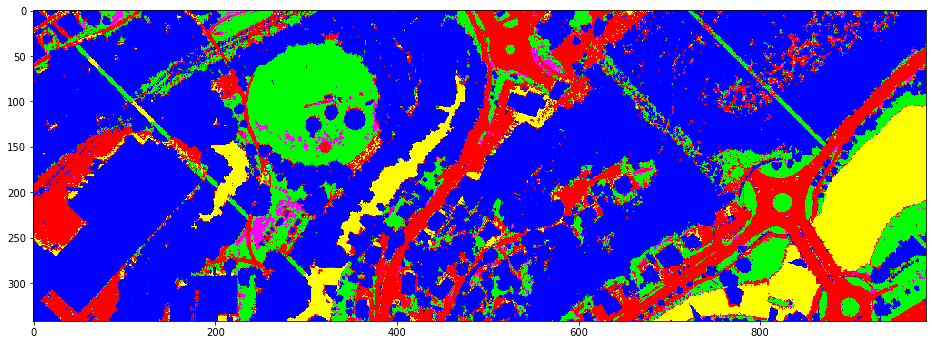

In [94]:
val_pred_full = random_forest3.predict(X_data_scaled)
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [95]:
df_val = pd.concat([df_lid_hsi, df_class_val], axis=1, sort=False)



In [96]:
df_val

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,NDVI,Lidar Intensity,Lidar nDSM,Target
0,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,16.0,29.960000,0
1,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,15.0,29.940000,0
2,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,16.0,29.940000,0
3,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,19.0,29.910000,0
4,15671.626963,2391.778723,1366.616803,2873.389560,-1426.981467,-256.357803,503.279098,0.000000,17.0,29.920000,0
...,...,...,...,...,...,...,...,...,...,...,...
336181,-8064.910934,-9739.830008,-3453.354840,-8706.614458,1378.451921,-1683.734928,11067.595105,-0.007535,23.0,0.009999,0
336182,-7837.351509,-8610.728510,-3706.605468,-8143.885480,3392.596091,293.014037,8223.361623,0.008403,25.0,0.010000,0
336183,-4391.655865,-7840.302319,-6476.892967,-10493.144030,6515.412895,1668.413859,9734.503741,-0.007376,23.0,0.090000,0
336184,-4877.482333,-7526.412976,-6535.301045,-11488.744431,5705.424739,1637.411175,9927.133068,-0.011854,19.0,0.040001,0


In [97]:
df_masked_val = df_val[(df_val[['Target']] != 0).all(axis=1)]
X_val = df_masked_val.drop(columns=['Target']).values
y_val = df_masked_val['Target'].values

In [98]:
X_data_scaled_val = scaler3.transform(X_val)
val_pred_full_ = random_forest3.predict(X_data_scaled_val)

In [99]:
accuracy_score(y_val, val_pred_full_)

0.7996658402500808

In [100]:
target_names = ['Road', 'Vegetation','Water', 'Unclassified', 'Soil', 'Train Track']
print(classification_report(y_val, val_pred_full_, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.88      1.00      0.93      3456
  Vegetation       0.99      0.64      0.78      5566
       Water       0.59      0.99      0.74      4439
Unclassified       0.98      0.83      0.90      4135
        Soil       0.87      0.03      0.05       940
 Train Track       0.00      0.00      0.00        18

    accuracy                           0.80     18554
   macro avg       0.72      0.58      0.57     18554
weighted avg       0.86      0.80      0.79     18554



In [101]:
cohen_kappa_score(y_val, val_pred_full_)

0.7377269861367901

In [102]:
confusion_matrix(y_val, val_pred_full_)

array([[3443,    0,    5,    4,    1,    3],
       [  33, 3563, 1952,   15,    3,    0],
       [  44,    0, 4393,    2,    0,    0],
       [  58,    0,  664, 3412,    0,    1],
       [ 315,   45,  476,   55,   26,   23],
       [  17,    0,    0,    1,    0,    0]])